# **Feature Importance**

**Connect Google Drive**

In [1]:
!pip -q install xgboost lightgbm scikit-learn==1.4.2

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 33.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.4.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.


In [2]:
import seaborn as sns

In [4]:
!pip -q install scikit-learn==1.4.2

import os
import numpy as np
import pandas as pd

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

drive.mount('/content/drive')

folder = "/content/drive/MyDrive/CSE 4262 Project"
file_name = "Preprocessed_Churn_PySpark.csv"
file_path = os.path.join(folder, file_name)

df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)
df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded: /content/drive/MyDrive/CSE 4262 Project/Preprocessed_Churn_PySpark.csv
Shape: (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,-1.277354,0,2,1,0,1,0,0,0,0,0,1,0,-1.160241,-0.994169,0
1,1,0,0,0,0.066323,1,0,1,1,0,1,0,0,0,1,0,1,-0.259611,-0.173230,0
2,1,0,0,0,-1.236636,1,0,1,1,1,0,0,0,0,0,1,1,-0.362635,-0.959603,1


**Feature and Label split**

In [5]:
print("\nTarget distribution (Churn):")
print(df["Churn"].value_counts(dropna=False).rename({0:"No",1:"Yes"}))

print("\nDtypes:")
print(df.dtypes)

# Split features/label
y = df["Churn"].astype(int).values
X = df.drop(columns=["Churn"])
feature_names = X.columns.tolist()

print("\nX shape:", X.shape, " y shape:", y.shape)


Target distribution (Churn):
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Dtypes:
gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure              float64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

X shape: (7043, 19)  y shape: (7043,)


**Train/Test Split + Handle Class Imbalance**

In [6]:
# Split into train/validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Compute imbalance ratio for boosting algorithms
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)

print(f"Train size: {X_train.shape}, Valid size: {X_valid.shape}")
print(f"Class balance -> positives={pos}, negatives={neg}, scale_pos_weight={scale_pos_weight:.2f}")

Train size: (5634, 19), Valid size: (1409, 19)
Class balance -> positives=1495, negatives=4139, scale_pos_weight=2.77


**Random Forest Feature Importance**

In [7]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

fi_rf = pd.Series(rf.feature_importances_, index=feature_names, name="RF")
print("Top 5 (RF):")
print(fi_rf.sort_values(ascending=False).head())

Top 5 (RF):
TotalCharges      0.154427
tenure            0.151394
MonthlyCharges    0.135475
Contract          0.132715
OnlineSecurity    0.062427
Name: RF, dtype: float64


**XGBoost Feature Importance**

In [8]:
xgb = XGBClassifier(
    n_estimators=600,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method="hist",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

fi_xgb = pd.Series(xgb.feature_importances_, index=feature_names, name="XGB")
print("Top 5 (XGB):")
print(fi_xgb.sort_values(ascending=False).head())

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:04:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top 5 (XGB):
Contract           0.346482
InternetService    0.150459
OnlineSecurity     0.097045
TechSupport        0.073280
tenure             0.032895
Name: XGB, dtype: float32


**LightGBM Feature Importance**

In [9]:

lgbm = LGBMClassifier(
    n_estimators=800,
    max_depth=-1,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    verbose=-1                 # suppress training logs
)
lgbm.fit(X_train, y_train)

fi_lgb = pd.Series(lgbm.feature_importances_, index=feature_names, name="LGBM")
print("Top 5 (LGBM):")
print(fi_lgb.sort_values(ascending=False).head())


Top 5 (LGBM):
MonthlyCharges    6583
TotalCharges      5947
tenure            3913
PaymentMethod     1299
gender             828
Name: LGBM, dtype: int32


**Combine Rankings**

In [10]:
# 1) Combine importances
fi_all = pd.concat([fi_rf, fi_xgb, fi_lgb], axis=1).fillna(0.0)

# 2) Normalize each model separately
def minmax(s):
    rng = s.max() - s.min()
    return (s - s.min()) / (rng if rng != 0 else 1.0)

fi_norm = fi_all.apply(minmax, axis=0)

# 3) Equal-weight average score
fi_norm["MeanScore"] = fi_norm.mean(axis=1)

# 4) Rank by MeanScore
ranks = fi_norm["MeanScore"].rank(ascending=False, method="min").astype(int)

# 5) Build summary with clear column names
summary = pd.DataFrame({
    "Rank": ranks,
    "MeanScore": fi_norm["MeanScore"],
    "RF_Importance": fi_all["RF"],
    "XGB_Importance": fi_all["XGB"],
    "LGBM_Importance": fi_all["LGBM"]
}).sort_values("MeanScore", ascending=False)

top_summary = summary.head(19).style.background_gradient(
    cmap="Blues", subset=["MeanScore"]
).bar(subset=["MeanScore"], color="lightgreen").format({
    "MeanScore": "{:.3f}",
    "RF_Importance": "{:.4f}",
    "XGB_Importance": "{:.4f}",
    "LGBM_Importance": "{:.4f}"
})

display(top_summary)

,Rank,MeanScore,RF_Importance,XGB_Importance,LGBM_Importance
Contract,1,0.644,0.1327,0.3465,601.0000
TotalCharges,2,0.640,0.1544,0.0202,5947.0000
MonthlyCharges,3,0.632,0.1355,0.0215,6583.0000
tenure,4,0.541,0.1514,0.0329,3913.0000
InternetService,5,0.237,0.0485,0.1505,150.0000
OnlineSecurity,6,0.227,0.0624,0.0970,381.0000
PaymentMethod,7,0.194,0.0586,0.0262,1299.0000
TechSupport,8,0.182,0.0533,0.0733,382.0000
OnlineBackup,9,0.086,0.0275,0.0265,529.0000
gender,10,0.080,0.0218,0.0182,828.0000


# **EDA**

**Correlation with Churn**

,Feature,CorrelationWithChurn
0,InternetService,0.317
1,MonthlyCharges,0.193
2,PaperlessBilling,0.192
3,SeniorCitizen,0.151
4,MultipleLines,0.019
5,PhoneService,0.012
6,gender,-0.009
7,Partner,-0.150
8,Dependents,-0.164
9,TotalCharges,-0.199


/tmp/ipython-input-79112830.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Feature", x="CorrelationWithChurn", data=corr_table, palette="coolwarm")


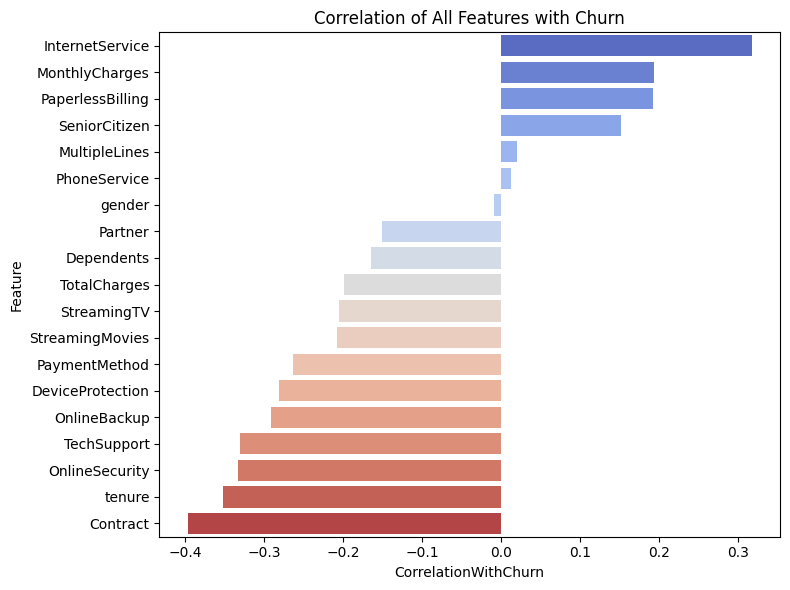

In [11]:
# ===== Correlation with Churn =====
corr_with_y = (
    X.assign(Churn=y)
    .corr(numeric_only=True)["Churn"]
    .drop("Churn")
    .sort_values(ascending=False)
)

# Show as a full table
corr_table = pd.DataFrame(corr_with_y).reset_index()
corr_table.columns = ["Feature", "CorrelationWithChurn"]

display(corr_table.style.background_gradient(
    cmap="RdBu_r", subset=["CorrelationWithChurn"]
).format({"CorrelationWithChurn": "{:.3f}"}))

# Plot all correlations
plt.figure(figsize=(8, 6))
sns.barplot(y="Feature", x="CorrelationWithChurn", data=corr_table, palette="coolwarm")
plt.title("Correlation of All Features with Churn")
plt.tight_layout()
plt.show()


**Feature Importance Summary**

,Rank,MeanScore,RF_Importance,XGB_Importance,LGBM_Importance
Contract,1,0.644,0.1327,0.3465,601.0000
TotalCharges,2,0.640,0.1544,0.0202,5947.0000
MonthlyCharges,3,0.632,0.1355,0.0215,6583.0000
tenure,4,0.541,0.1514,0.0329,3913.0000
InternetService,5,0.237,0.0485,0.1505,150.0000
OnlineSecurity,6,0.227,0.0624,0.0970,381.0000
PaymentMethod,7,0.194,0.0586,0.0262,1299.0000
TechSupport,8,0.182,0.0533,0.0733,382.0000
OnlineBackup,9,0.086,0.0275,0.0265,529.0000
gender,10,0.080,0.0218,0.0182,828.0000


/tmp/ipython-input-1648438917.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=summary_all.index, x="MeanScore", data=summary_all, palette="viridis")


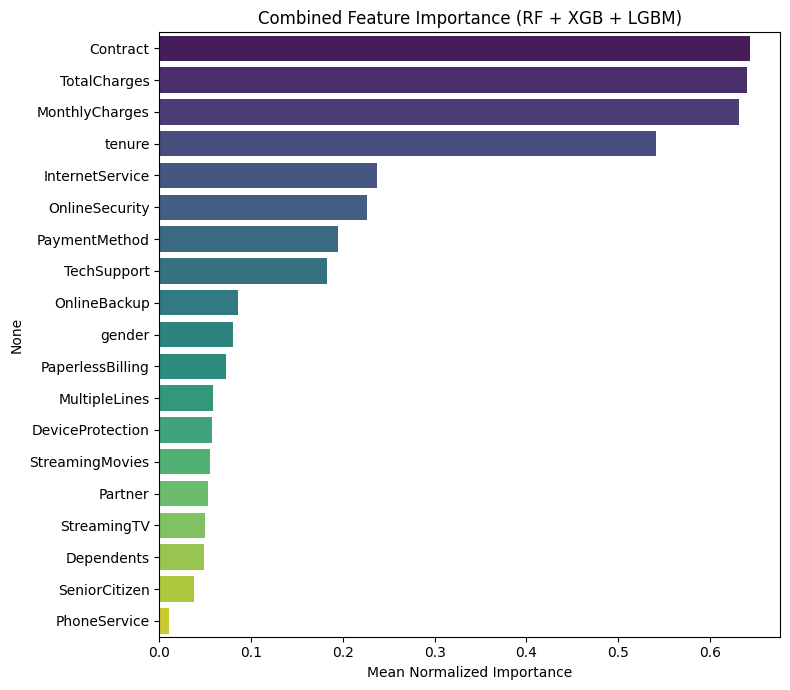

In [12]:
# ===== Combined Feature Importance =====
summary_all = summary.sort_values("Rank")  # already has Rank + MeanScore

display(summary_all.style.background_gradient(
    cmap="Blues", subset=["MeanScore"]
).bar(subset=["MeanScore"], color="lightgreen").format({
    "MeanScore": "{:.3f}",
    "RF_Importance": "{:.4f}",
    "XGB_Importance": "{:.4f}",
    "LGBM_Importance": "{:.4f}"
}))

# Plot all features by MeanScore
plt.figure(figsize=(8, 7))
sns.barplot(y=summary_all.index, x="MeanScore", data=summary_all, palette="viridis")
plt.title("Combined Feature Importance (RF + XGB + LGBM)")
plt.xlabel("Mean Normalized Importance")
plt.tight_layout()
plt.show()

**Churn Rate by Categorical Features**

/tmp/ipython-input-1590027366.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Churn", data=churn_rate, palette="viridis")


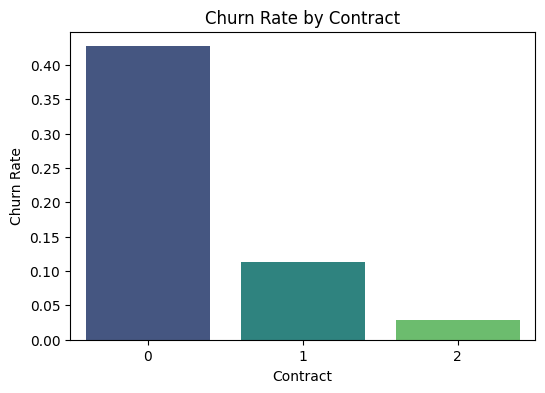

/tmp/ipython-input-1590027366.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Churn", data=churn_rate, palette="viridis")


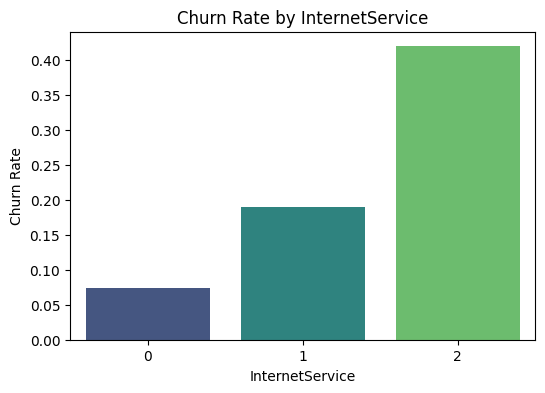

/tmp/ipython-input-1590027366.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Churn", data=churn_rate, palette="viridis")


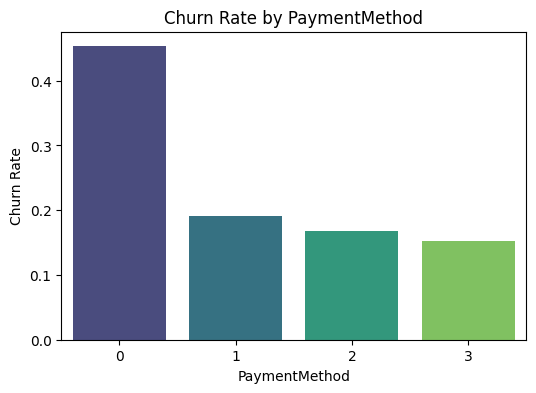

/tmp/ipython-input-1590027366.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Churn", data=churn_rate, palette="viridis")


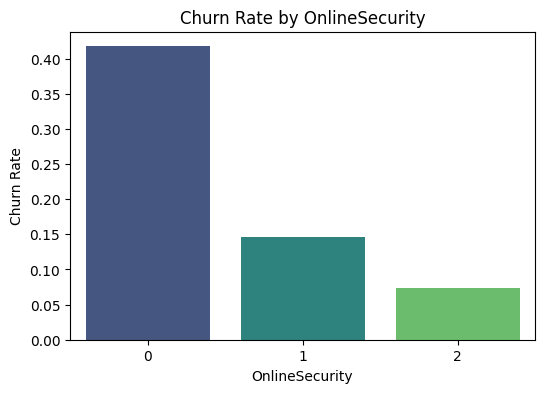

/tmp/ipython-input-1590027366.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Churn", data=churn_rate, palette="viridis")


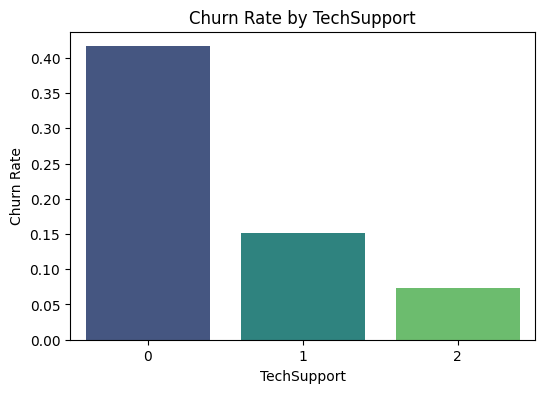

/tmp/ipython-input-1590027366.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Churn", data=churn_rate, palette="viridis")


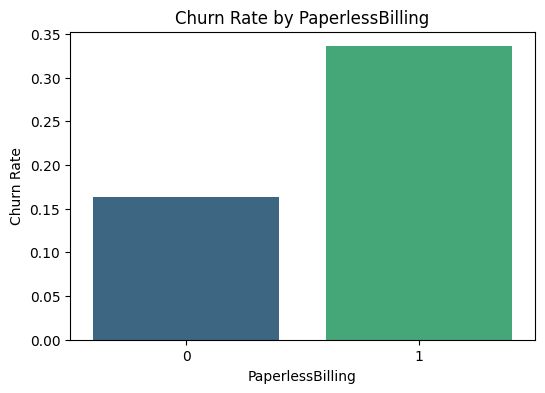

In [13]:
cat_features = ["Contract", "InternetService", "PaymentMethod",
                "OnlineSecurity", "TechSupport", "PaperlessBilling"]

for col in cat_features:
    churn_rate = df.groupby(col)["Churn"].mean().reset_index()
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y="Churn", data=churn_rate, palette="viridis")
    plt.title(f"Churn Rate by {col}")
    plt.ylabel("Churn Rate")
    plt.show()

**Distribution of Continuous Features by Churn**

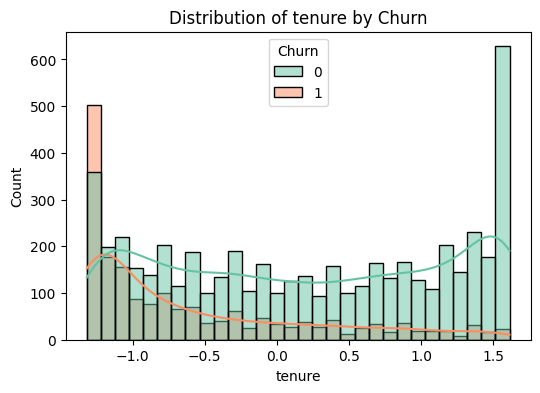

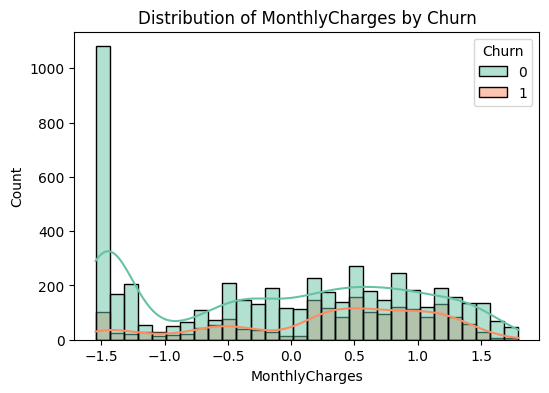

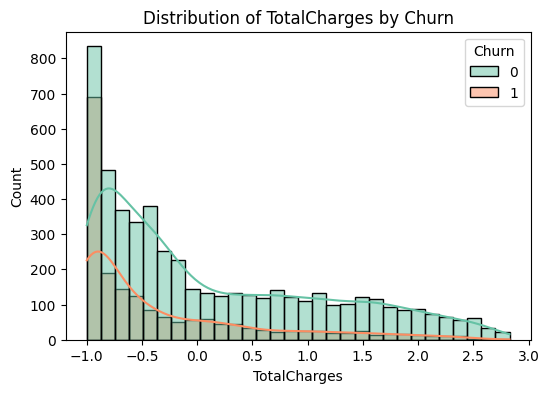

In [14]:
num_features = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in num_features:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, hue="Churn", kde=True, bins=30, palette="Set2")
    plt.title(f"Distribution of {col} by Churn")
    plt.show()

/tmp/ipython-input-3651101883.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Churn", y=col, palette="Set3")


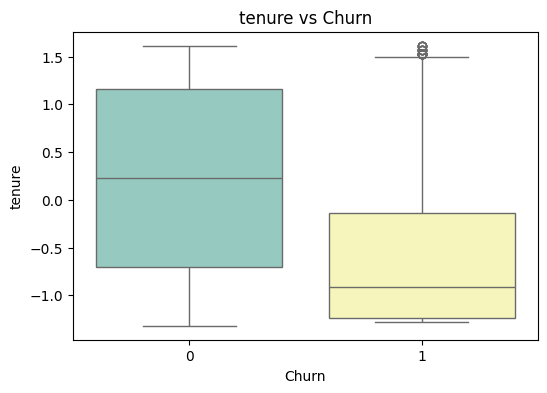

/tmp/ipython-input-3651101883.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Churn", y=col, palette="Set3")


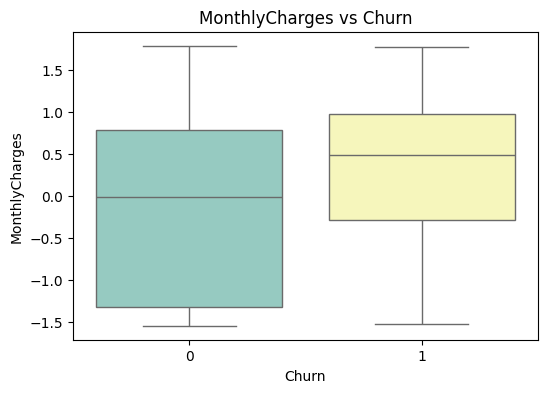

/tmp/ipython-input-3651101883.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Churn", y=col, palette="Set3")


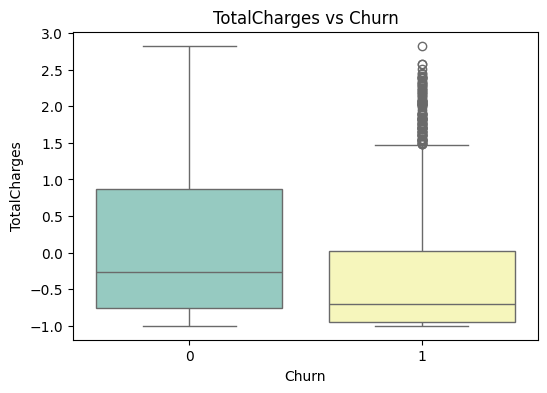

In [15]:
for col in num_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="Churn", y=col, palette="Set3")
    plt.title(f"{col} vs Churn")
    plt.show()


**Heatmap of All Feature Correlations**

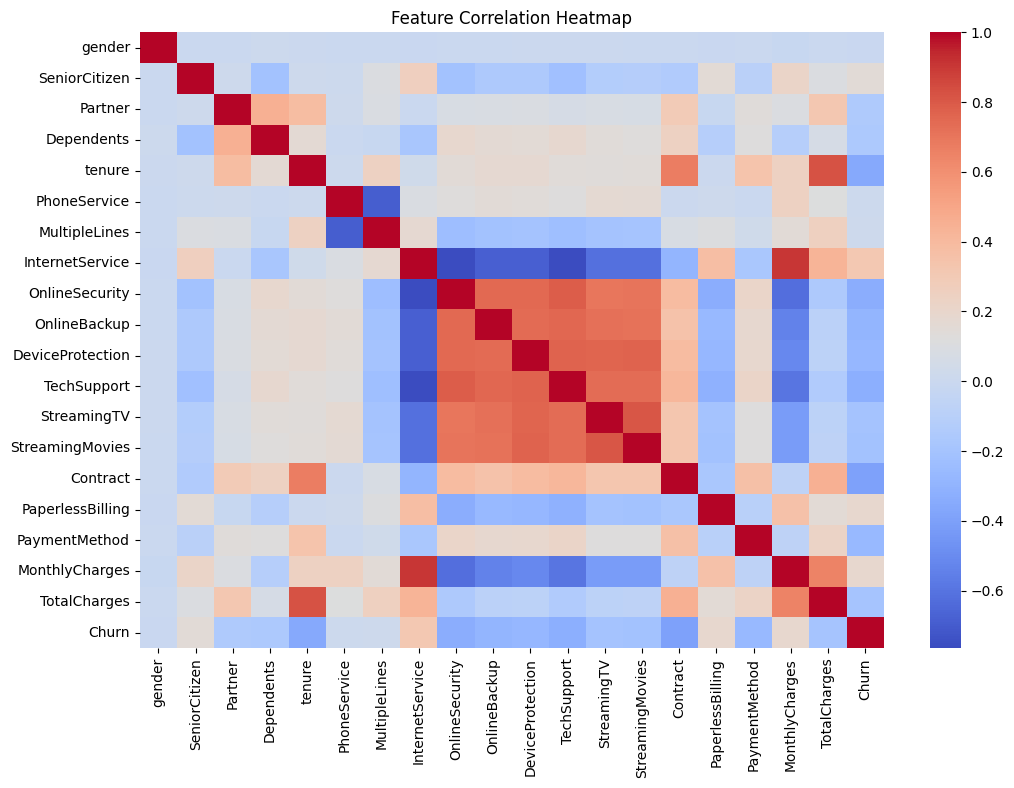

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


Churn Distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn Percentage:
Churn
0    73.46
1    26.54
Name: proportion, dtype: float64


/tmp/ipython-input-410303460.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")


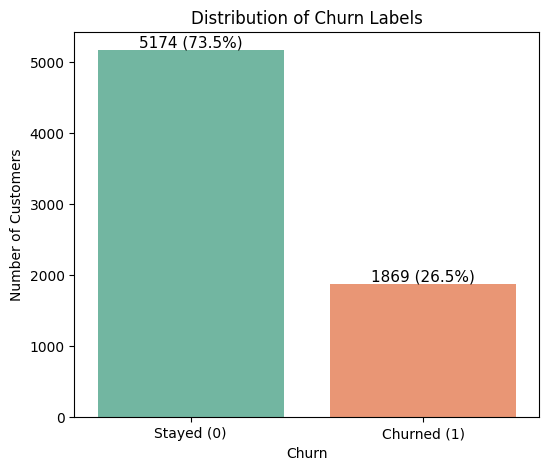

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Churn label distribution ---
label_counts = df["Churn"].value_counts().sort_index()
label_percent = df["Churn"].value_counts(normalize=True).sort_index() * 100

print("Churn Distribution:")
print(label_counts)
print("\nChurn Percentage:")
print(label_percent.round(2))

# --- Barplot ---
plt.figure(figsize=(6,5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.xticks([0, 1], ["Stayed (0)", "Churned (1)"])
plt.ylabel("Number of Customers")
plt.title("Distribution of Churn Labels")
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 50, f"{v} ({label_percent.iloc[i]:.1f}%)",
             ha="center", fontsize=11)
plt.show()
